# Hedging Goals

## Packages

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import pandas as pd
from scipy.optimize import fsolve
from scipy.optimize import root
from scipy.stats import beta
from scipy.stats import norm
import tensorflow as tf
from tensorflow.keras import initializers, optimizers
import tensorflow.keras.backend as K
from tensorflow.keras.backend import constant, zeros_like
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.layers import Add, add, Concatenate, Dense, Dot, Input, Lambda, Layer, maximum, minimum, Multiply, Subtract, subtract
from tensorflow.keras.models import model_from_json, load_model, Model, Sequential
from tensorflow.keras.utils import plot_model

In [2]:
print(datetime.now().time().strftime("%H:%M:%S"))

14:42:40


## Connect to Google Directory

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
images_dir='/content/gdrive/My Drive/graphics/Hedging_Goals/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
print(datetime.now().time().strftime("%H:%M:%S"))

14:42:40


## Scenario Parameters

In [5]:
dt=1/52
maturity=10
nScenarios=10**4
nTest=10**4
mu=0.08
r=0.01
sigma=0.30
S0=100.
strike=100.
tc=0.005
h0=0.
w0=70.
target=1/maturity*np.log(100/w0)
lmbda=0.1

In [6]:
N=int(maturity/dt)

In [7]:
print(datetime.now().time().strftime("%H:%M:%S"))

14:42:40


## Configuration of the Neural Networks

In [8]:
nodes=10
depth=2
layers=[]
for k in range(N):
    l=0
    while l<depth:
        layer=Dense(nodes,activation='sigmoid',trainable=True,
            kernel_initializer='random_normal',bias_initializer='random_normal',
            name=str(k*(depth+1)+l))
        layers=layers+[layer]
        l+=1
    layer=Dense(1,activation='sigmoid',trainable=True,
        kernel_initializer='random_normal',bias_initializer='random_normal',
        name=str(k*(depth+1)+l))
    layers=layers+[layer]

In [9]:
print(datetime.now().time().strftime("%H:%M:%S"))

14:42:41


## Tensor Operations

In [10]:
import sys
#print(sys.getrecursionlimit())
sys.setrecursionlimit(4000)

In [11]:
wealth=Input(shape=(1,))
hedge=Input(shape=(1,))
price=Input(shape=(1,))
inputs=[wealth,hedge,price]
outputs=[]
depot=Multiply()([hedge,price])
bank_account=Subtract()([wealth,depot])
for k in range(N):
    moneyness=Lambda(lambda x:x/strike)(price)
    NN_input=Concatenate()([hedge,moneyness])
    hedge_new=layers[k*(depth+1)](NN_input)
    for l in range(depth):
        hedge_new=layers[k*(depth+1)+l+1](hedge_new)
    hedge_delta=Subtract()([hedge_new,hedge])
    hedge_delta_abs=Lambda(lambda x:K.abs(x))(hedge_delta)
    cost=Multiply()([hedge_delta_abs,price])
    cost=Lambda(lambda x:tc*x)(cost)
    face_amount=Multiply()([hedge_delta,price])
    cost=Add()([cost,face_amount])
    bank_account=Subtract()([bank_account,cost])
    hedge=hedge_new
    rtrn=Input(shape=(1,))
    price=Multiply()([price,rtrn])
    depot=Multiply()([hedge,price])
    bank_account=Lambda(lambda x:x*np.exp(r*dt))(bank_account)
    wealth=Add()([depot,bank_account])
    inputs=inputs+[rtrn]
    outputs=outputs+[hedge_new]
hedge_abs=Lambda(lambda x:K.abs(x))(hedge)
cost=Multiply()([hedge_abs,price])
cost=Lambda(lambda x:tc*x)(cost)
wealth=Subtract()([wealth,cost])
outputs=[wealth]+outputs
outputs=Concatenate()(outputs)
model=Model(inputs=inputs,outputs=outputs)

In [12]:
print(datetime.now().time().strftime("%H:%M:%S"))

14:43:14


## Scenarios

### Training Data

In [13]:
x_train=([w0*np.ones(nScenarios)]+[h0*np.ones(nScenarios)]+[S0*np.ones(nScenarios)]+[np.exp((mu-1/2*sigma**2)*dt+sigma*np.sqrt(dt)*np.random.normal(0,1,nScenarios)) for k in range(N)])
S_T_train=x_train[2]
for k in range(N):
    S_T_train=S_T_train*x_train[k+3]
y_train=np.zeros((nScenarios,N+1))
y_train[:,0]=w0*np.exp(target*maturity)*np.ones(nScenarios)

### Validation Data

In [14]:
x_test=([w0*np.ones(nTest)]+[h0*np.ones(nTest)]+[S0*np.ones(nTest)]+[np.exp((mu-1/2*sigma**2)*dt+sigma*np.sqrt(dt)*np.random.normal(0,1,nTest)) for k in range(N)])
S_T_test=x_test[2]
for k in range(N):
    S_T_test=S_T_test*x_test[k+3]
y_test=np.zeros((nTest,N+1))
y_test[:,0]=w0*np.exp(target*maturity)*np.ones(nTest)

In [15]:
print(datetime.now().time().strftime("%H:%M:%S"))

14:43:15


## Loss Function and Optimiser

In [16]:
# loss function
plan=[1,1.5,2,5]
p=plan[3]
def custom_loss(y_true,y_pred):
    return K.mean(K.pow(K.softplus(y_true[:,0]-y_pred[:,0]),p)+lmbda*K.maximum(y_pred[:,0]-y_true[:,0],0))

In [17]:
# config optimiser
batch_size=64
epochs=500
use_adam=True
if (use_adam==True):
    model.compile(optimizer='adam',loss=custom_loss)
else:
    lr=0.05
    optimiser=optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimiser,loss=custom_loss)

In [18]:
print(datetime.now().time().strftime("%H:%M:%S"))

14:43:15


## Benchmark

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in power


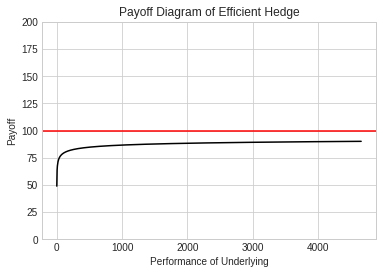

empirical minimal loss: 4278521.69


In [19]:
alpha=(mu-r)/sigma**2

def d2(spot_price,strike,rf,vola,time_to_mat):
    return (np.log(spot_price/strike)+(rf-1/2*vola**2)*time_to_mat)/(vola*np.sqrt(time_to_mat))

def efficient_hedge(spot_price,strike,rf,vola,time_to_mat,desired_payoff,p):
    if (time_to_mat==0):
        if (spot_price>=strike):
            aux=1e16
        else:
            aux=-1e16
    else:
        aux=d2(spot_price,strike,rf,vola,time_to_mat)
    output=norm.cdf(aux)
    if (p>1):
        alpha_p=alpha/(p-1)
        output=output-(strike/spot_price)**alpha_p*np.exp(alpha_p*(alpha_p+1)*(vola**2/2-rf)*time_to_mat)*\
            norm.cdf(aux-alpha_p*vola*np.sqrt(time_to_mat))
    output=np.exp(-rf*time_to_mat)*desired_payoff*output
    return output

vec_efficient_hedge=np.vectorize(efficient_hedge,excluded=['strike','rf','vola','time_to_mat','desired_payoff','p'])

def strike_func(L):
    return efficient_hedge(S0,L,r,sigma,maturity,w0*np.exp(target*maturity),p)-w0
L=root(strike_func,strike,method='lm').x

suitable_window_max=max(S_T_train)
S_grid=np.linspace(1,suitable_window_max,1000)
payoff_grid=vec_efficient_hedge(S_grid,L,r,sigma,0,w0*np.exp(target*maturity),p)

plt.plot(S_grid,payoff_grid,color='black')
plt.axhline(w0*np.exp(target*maturity),color='red')
plt.ylim(0,200)
plt.title('Payoff Diagram of Efficient Hedge')
plt.xlabel('Performance of Underlying')
plt.ylabel('Payoff')
plt.savefig(f'{images_dir}/01_analytic_solution.pdf')
plt.show()

benchmark=np.reshape(vec_efficient_hedge(S_T_train,L,r,sigma,0,w0*np.exp(target*maturity),p),(-1,1))
minimal_loss=np.mean(np.power(np.maximum(y_train[:,0]-benchmark,0),p))
print('empirical minimal loss: {:.2f}'.format(minimal_loss))

## Training

Epoch 1/500
157/157 - 175s - loss: 158704768.0000
Epoch 2/500
157/157 - 20s - loss: 121737840.0000
Epoch 3/500
157/157 - 20s - loss: 97696016.0000
Epoch 4/500
157/157 - 20s - loss: 77953264.0000
Epoch 5/500
157/157 - 19s - loss: 62061388.0000
Epoch 6/500
157/157 - 19s - loss: 49599396.0000
Epoch 7/500
157/157 - 19s - loss: 40000876.0000
Epoch 8/500
157/157 - 19s - loss: 32688296.0000
Epoch 9/500
157/157 - 19s - loss: 27135660.0000
Epoch 10/500
157/157 - 19s - loss: 22875852.0000
Epoch 11/500
157/157 - 19s - loss: 19623922.0000
Epoch 12/500
157/157 - 20s - loss: 17118680.0000
Epoch 13/500
157/157 - 20s - loss: 15122820.0000
Epoch 14/500
157/157 - 20s - loss: 13526166.0000
Epoch 15/500
157/157 - 20s - loss: 12227256.0000
Epoch 16/500
157/157 - 19s - loss: 11170134.0000
Epoch 17/500
157/157 - 19s - loss: 10275684.0000
Epoch 18/500
157/157 - 19s - loss: 9534352.0000
Epoch 19/500
157/157 - 19s - loss: 8906363.0000
Epoch 20/500
157/157 - 19s - loss: 8371524.5000
Epoch 21/500
157/157 - 19s - 

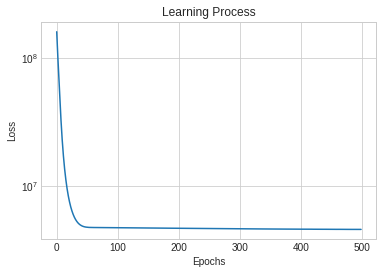

In [20]:
# training

#plt.savefig(f'{images_dir}/histogram_'+str(p)+'_'+str(tc)+'.pdf')
plt.show()
for i in range(1):
    model.fit(x=x_train,y=y_train,batch_size=batch_size,epochs=epochs,verbose=2)
plt.plot(model.history.history['loss'])
plt.title('Learning Process')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.savefig(f'{images_dir}/02_loss_over_training.pdf')
plt.show()

## Validation

In [21]:
performance_train=model.predict(x_train)
performance_test=model.predict(x_test)

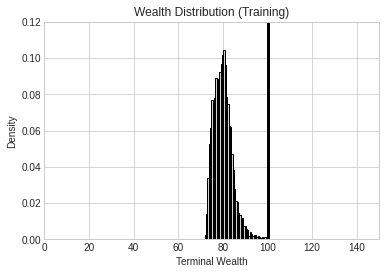

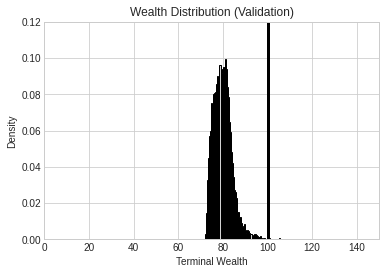

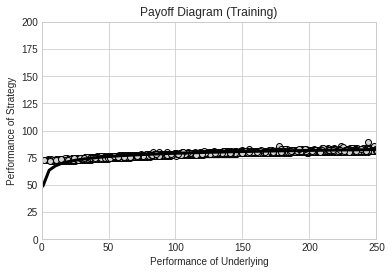

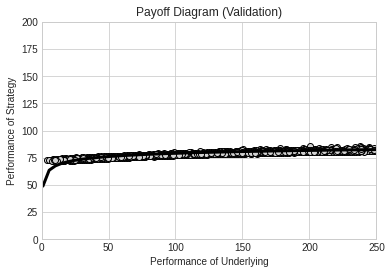

In [22]:
plt.hist(model.predict(x_train)[:,0],density=True,bins=100,color='lightgray',edgecolor='black')
plt.axvline(w0*np.exp(target*maturity),color='black',linewidth=3)
plt.title('Wealth Distribution (Training)')
plt.xlabel('Terminal Wealth')
plt.ylabel('Density')
plt.xlim((0,150))
plt.ylim((0,0.12))
plt.savefig(f'{images_dir}/03_hist_training.pdf')
plt.show()
plt.hist(performance_test[:,0],density=True,bins=100,color='lightgray',edgecolor='black')
plt.axvline(w0*np.exp(target*maturity),color='black',linewidth=3)
plt.title('Wealth Distribution (Validation)')
plt.xlabel('Terminal Wealth')
plt.ylabel('Density')
plt.xlim((0,150))
plt.ylim((0,0.12))
plt.savefig(f'{images_dir}/03_hist_validation.pdf')
plt.show()
plt.scatter(S_T_train,performance_train[:,0],color='lightgray',edgecolor='black')
plt.plot(S_grid,payoff_grid,color='black',linewidth=3)
plt.title('Payoff Diagram (Training)')
plt.xlabel('Performance of Underlying')
plt.ylabel('Performance of Strategy')
plt.xlim((0,250))
plt.ylim((0,200))
plt.savefig(f'{images_dir}/04_performance_in_sample.pdf')
plt.show()
plt.scatter(S_T_test,performance_test[:,0],color='lightgray',edgecolor='black')
plt.plot(S_grid,payoff_grid,color='black',linewidth=3)
plt.title('Payoff Diagram (Validation)')
plt.xlabel('Performance of Underlying')
plt.ylabel('Performance of Strategy')
plt.xlim((0,250))
plt.ylim((0,200))
plt.savefig(f'{images_dir}/04_performance_out_of_sample.pdf')
plt.show()

In [23]:
#temp=np.column_stack((np.reshape(S_T_train,(-1,1)),benchmark,performance_train[:,0]))
#np.savetxt('temp.csv',temp,delimiter=',')

In [24]:
print(datetime.now().time().strftime("%H:%M:%S"))

17:27:40


In [25]:
temp_display_strategies=False
if temp_display_strategies==True:
    S_T_test=x_test[2]
    for k in range(maturity-1):
        plt.scatter(S_T_test,performance_test[:,1+k*int(1/dt)])
        plt.title('Replication Strategy in the Year '+str(k+1))
        plt.xlabel('Performance of Underlying')
        plt.ylabel('Investment')
        plt.xlim((0,suitable_window_max))
        plt.ylim((0,2))
        plt.show()
        for l in range(k*int(1/dt),(k+1)*int(1/dt)):
            S_T_test=S_T_test*x_test[l+3]

In [26]:
print(datetime.now().time().strftime("%H:%M:%S"))

17:27:40


In [27]:
model.save(images_dir+'model_trained.h5')
print('model saved to disc')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


model saved to disc
